# Collocation algorithms

Yet another method involves invoking our interpolator methods to model the solution directly. The process is:

1. Determine a set of (possibly unevenly spaced) points, $x_i$.
2. Define an interpolator function with *unknown* parameters $w_i$.
3. Apply the ODE at each point and find a residual, $R(w_i) = y^\prime(w_i) - f\big(x_i, y_i(w_i)\big)$
4. Solve (root find or in least squares) for the interpolator parameters.

We can apply a number of interpolators to this scheme, but some common ones include:
- Splines (1D / 2D)
- Radial Basis Functions (ND)
- Neural Networks
- Spectral methods

Spectral methods in this context refers to the use of special basis functions (Sin / cos, Chebychev, Legenre polynomials, etc) with associated optimal collocation points.

## Pros / Cons

**Benefits:**
- Flexibility: Can handle complex geometries and irregular domains.
- High Accuracy: Often provides high accuracy with fewer collocation points, especially with higher-order polynomials.
- Versatility: Suitable for a wide range of problems, including ODEs and PDEs.
- Spectral Methods: Achieve exponential convergence for smooth problems when using spectral collocation (e.g., Chebyshev or Legendre polynomials).

**Drawbacks:**
- Complexity: More complex to implement compared to FDM, especially for higher-order methods.
- Computational Cost: Can be computationally expensive due to the need to solve large systems of equations.
- Stability: Requires careful selection of collocation points to ensure stability and convergence.

#### Example: Splines

$$ \frac{\partial^2 y}{\partial t^2} = -g, \quad   y(0) = 0, y(5) = 50 $$

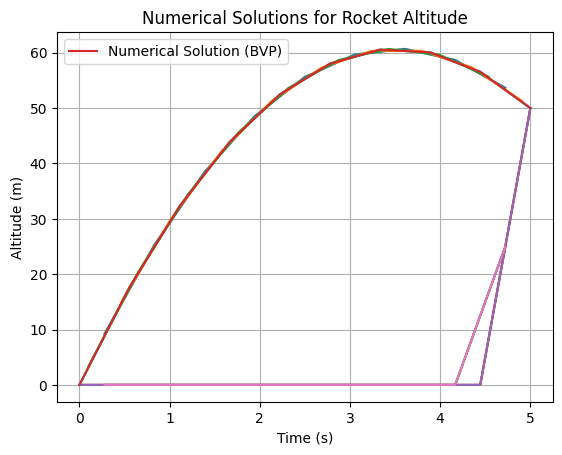

In [ ]:
def fun(x, y):
  plt.plot(x,y[0])
  return np.vstack((y[1], -9.8*np.ones_like(y[1])))

def bc(ya, yb):
  return np.array([ya[0], yb[0] - 50])

x = np.linspace(0, 5, 10)
y = np.zeros((2, x.size))
y[0, 0] = 0
y[0, -1] = 50
sol = solve_bvp(fun, bc, x, y)

# Plot the solution from solve_bvp
plt.plot(sol.x, sol.y[0], label='Numerical Solution (BVP)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Numerical Solutions for Rocket Altitude')
plt.legend()
plt.grid(True)
plt.show()


#### Example: RBFs
Use RBFs to solve

$$ \nabla^2 u = 4$$
on the unit square where $u(x=0,1,y) = u(x, y=0,1) = 0$.

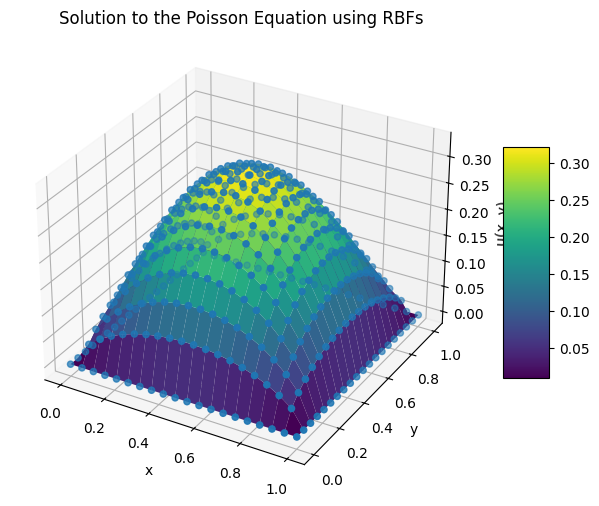

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib import cm

# Parameters
N = 20  # Number of nodes in each direction (NxN grid)
epsilon = N/np.sqrt(2)  # Shape parameter for RBFs

# Define the RBF (we use a Gaussian RBF in this example)
def rbf(r, epsilon):
    return np.exp(-(epsilon * r) ** 2)

# Define the Laplacian of the RBF (for the Poisson equation)
def laplacian_rbf(r, epsilon):
    return (4 * epsilon**2 - 4 * epsilon**4 * r**2) * np.exp(-(epsilon * r) ** 2)

# Generate nodes in a square domain [0,1]x[0,1]
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T

#points = np.random.uniform(0, 1, (N**2, 2))

# Compute pairwise distance matrix
r = cdist(points, points)

# Build the RBF matrix and Laplacian matrix
A = rbf(r, epsilon)
L = laplacian_rbf(r, epsilon)

# Define right-hand side (RHS) for Poisson equation
rhs = np.full(points.shape[0], 4.0)

# Apply boundary conditions (u=0 on the boundary)
boundary_indices = np.where((points[:, 0] == 0) | (points[:, 0] == 1) |
                            (points[:, 1] == 0) | (points[:, 1] == 1))[0]
interior_indices = np.setdiff1d(np.arange(points.shape[0]), boundary_indices)

# Modify RHS and matrices to incorporate Dirichlet BCs
rhs[boundary_indices] = 0
A[boundary_indices, :] = 0
A[boundary_indices, boundary_indices] = 1
L[boundary_indices, :] = 0
L[boundary_indices, boundary_indices] = 1

# Solve for the weights
weights = np.linalg.solve(L, rhs)

# Calculate solution u as a weighted sum of RBFs
u = A @ weights

# Reshape solution to 2D grid
U = u.reshape(N, N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, U, cmap=cm.viridis)
ax.scatter(points[:,0], points[:,1], u)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x, y)")
ax.set_title("Solution to the Poisson Equation using RBFs")
plt.show()
